# PROJECT 3: Assignment 3

###### Submitted By:
<table style="float:left">
    <tr>
        <th style="text-align:left"><b>Name</b></th> 
        <th style="text-align:center">Paras Kaushik</th>
    </tr>
    <tr>
        <th style="text-align:left"><b>Application Number</b></th> 
        <th style="text-align:center">4085303</th>
    </tr>
    <tr>
        <th style="text-align:left"><b>Acknowledge Number</b></th>
        <th style="text-align:center">3244</th>
    </tr>
    <tr>
        <th style="text-align:left"><b>Micronutrients</b></th>
        <th style="text-align:center">Vitamin: A, B, C, D, E, K</th>
    </tr>
</table>

<hr style="width:100%;height:2px;text-align:left;margin-left:0; background-color:black">

## Github Link


<hr style="width:100%;height:2px;text-align:left;margin-left:0; background-color:black">

## Objective

#### This program is utilized to fetch the articles associated with Vitamin deficiency from pubmed database. Details of the methods are provided.

<hr style="width:100%;height:2px;text-align:left;margin-left:0; background-color:black">

## Functionality

### Call fetch_pubmed to extract artciles from pubmed database 
<b>fetch_pubmed (keyword, mindate, maxdate)</b>: This function is to fetch artciles from pubmed database.
<ul>
    <li>keyword: Keyword list as parameters. In example we've pass "Vitamin Deficiency" as parameter.</li>
    <li>mindate: mindate as parameters. Default is 2010.</li>
    <li>maxdate: maxdate as parameters. Default is 2020.</li>
</ul> 

<hr style="width:100%;height:2px;text-align:left;margin-left:0; background-color:black">

## Code

In [33]:
# Importing requests for programmatic access to databases through APIs
import requests

# Importing pandas for dataframe operations
import pandas as pd

# Library to parse xml response from pubmed
import xml.etree.ElementTree as ET

# Library to create wordcloud
from wordcloud import WordCloud

# Library to create graphical analysis
import matplotlib.pyplot as plt

# Initiating vizuals as a result in cell
%matplotlib inline

In [21]:
# Function to fetch article abstracts from pubmed with PMID
def fetch_pubmed(keyword, mindate = 2010, maxdate = 2020):
    
    # Initializing database name and API url
    db = 'pubmed'; # Declaring the variable for pubmed database
    base = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'; # Initializing the base url for pubmed 
    
    ## Pubmed fetch pipeline
    # Pubmed - search util
    query = keyword.replace(' ','+')+'&mindate='+str(mindate)+'&maxdate='+str(maxdate); # Constructing search query for vitamins and time period
    url_search = base+'esearch.fcgi?db='+db+'&term='+query+'&usehistory=y&retmode=json'; # Constructing url for search query
    response_dict = requests.get(url_search).json() # Hitting the pubmed with serach util
    
    web = response_dict['esearchresult']['webenv'] # Extracting webenv for fetching articles
    key = response_dict['esearchresult']['querykey'] # Extracting queryKey for fetching articles
    count = response_dict['esearchresult']['count'] # Extracting count of total number of results
    restart=0 # initializing restart variable
    
    df = pd.DataFrame(columns = ['PMID', 'TITLE', 'YEAR','ABSTRACT']) # Create and empty dataframe to load the parsed data

    for x in range(0, int(count), 10000):
        
        url_fetch = base+'efetch.fcgi?db='+db+'&query_key='+key+'&WebEnv='+web+'&rettype=abstract&retmode=xml&retstart=retstart&retmax=10000';
        restart += 10000
        
        #url_fetch = base+'efetch.fcgi?db='+db+'&query_key='+key+'&WebEnv='+web+'&rettype=abstract&retmode=xml';

        response = requests.get(url_fetch) # fetch the response from URL
        re_xml = response.text # Read the response text

        # Parse the response
        tree = ET.ElementTree(ET.fromstring(re_xml)) # Parse the xml
        root = tree.getroot() # Find the root element of XML

        # loop over all the articles to fetch abstract
        for article in root.findall("PubmedArticle"):
            try:
                df = df.append({'PMID' : article.find(".//PMID").text,
                                'YEAR' : article.find(".//JournalIssue/PubDate/Year").text,
                                'TITLE': article.find(".//ArticleTitle").text,
                                'ABSTRACT' : article.find(".//AbstractText").text},
                                ignore_index = True)
            except:
                pass
    return df

In [24]:
# Call fetch_pubmed function to extract articles published with Vitamin Deficieny keyword between 2010 and 2020 (default timeline)
df = fetch_pubmed(keyword = 'Vitamin Deficiency')

In [44]:
df.to_csv('Vitaming_Deficiency.csv')

### Analysis


Distinct years with articles published ['2020' '2016' '2019' '2018' '2017']

Count of artcile accross years
 YEAR
2016     138
2017    5511
2018    7152
2019    7557
2020    4146
Name: ABSTRACT, dtype: int64


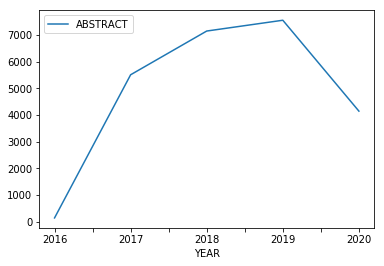

In [43]:
print ("\nDistinct years with articles published",df['YEAR'].unique())
print ("\nCount of artcile accross years\n",df.groupby(['YEAR'])['ABSTRACT'].count())
df.groupby(['YEAR'])['ABSTRACT'].count().plot(legend=True)

In [69]:
# Fill NA in articles with no abstract
df['ABSTRACT'] = df['ABSTRACT'].fillna('NA')

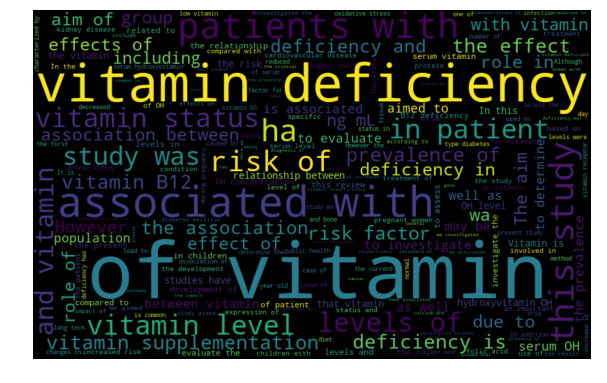

In [14]:
# Create word cloud
all_words = ' '.join([article for article in df['ABSTRACT']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

<hr style="width:100%;height:2px;text-align:left;margin-left:0; background-color:black">

## Topic Modelling

Unsupervised learning to analyzes text data to determine cluster words for a set of documents. Important in discovering the Abstract topics.

### Data Pre-processing

<OL>
    <li> <b>Tokenization</b>: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.</li>
<li> <b>Shot words</b>: Words that have fewer than 3 characters are removed.</li>
<li> <b>Stopwords</b>: All Stopwords are removed.</li>
<li> <b>Lemmatization</b>: words in third person are changed to first person and verbs in past and future tenses are changed into present.</li>
<li> <b>Stemming</b>: Words are reduced to their root form.</li>
</OL>

In [45]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

import nltk
nltk.download('wordnet')

C:\Users\paras.kaushik\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paras.kaushik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
# function to perform lemmatize and stem preprocessing
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [67]:
# Testing the function
doc_sample = df[df.index == 12].values[0][3]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Vitamin', 'D', 'works', 'by', 'binding', 'to', 'vitamin', 'D', 'receptor', '(VDR).', 'The', 'muscle', 'involvement', 'in', 'hypovitaminosis', 'D', 'was', 'broadly', 'named', 'osteomalacic', 'myopathy.']


 tokenized and lemmatized document: 
['vitamin', 'work', 'bind', 'vitamin', 'receptor', 'muscl', 'involv', 'hypovitaminosi', 'broad', 'name', 'osteomalac', 'myopathi']


In [70]:
# Preprocess the headline text, saving the results as ‘processed_docs’

processed_docs = df['ABSTRACT'].map(preprocess)
processed_docs[:10]

0    [report, associ, vitamin, exercis, perform, eq...
1    [vitamin, vitd, receptor, regul, express, gene...
2    [isol, central, posit, vertigo, cerebellar, in...
3    [inflammatori, bowel, diseas, patient, vitamin...
4    [investig, serum, vitamin, level, patient, new...
5    [partial, agonist, trpv, weak, activ, trpv, an...
6    [pregnanc, bariatr, surgeri, usual, consid, sa...
7    [recommend, vitamin, supplement, program, chil...
8    [reductas, mthfr, defici, autosom, recess, dis...
9    [vitamin, defici, chronic, obstruct, pulmonari...
Name: ABSTRACT, dtype: object

In [82]:
processed_docs[:10]

0    [report, associ, vitamin, exercis, perform, eq...
1    [vitamin, vitd, receptor, regul, express, gene...
2    [isol, central, posit, vertigo, cerebellar, in...
3    [inflammatori, bowel, diseas, patient, vitamin...
4    [investig, serum, vitamin, level, patient, new...
5    [partial, agonist, trpv, weak, activ, trpv, an...
6    [pregnanc, bariatr, surgeri, usual, consid, sa...
7    [recommend, vitamin, supplement, program, chil...
8    [reductas, mthfr, defici, autosom, recess, dis...
9    [vitamin, defici, chronic, obstruct, pulmonari...
Name: ABSTRACT, dtype: object

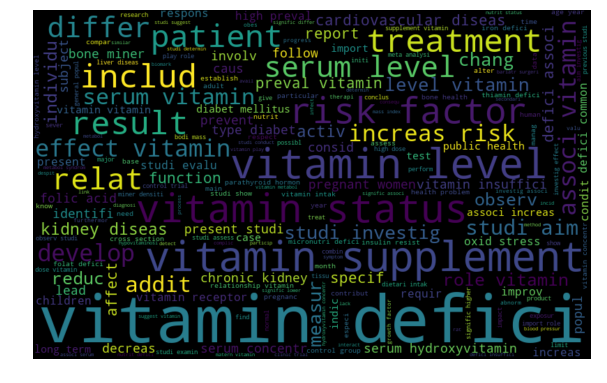

In [85]:
all_words = ' '.join([' '.join(article) for article in processed_docs])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Bag of words on the dataset

In [71]:
# Bag of Words on the Data set
## Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 adolesc
1 associ
2 athlet
3 author
4 complex
5 cortisol
6 equivoc
7 exercis
8 interplay
9 investig
10 male


In [80]:
print(dictionary)

Dictionary(4415 unique tokens: ['adolesc', 'associ', 'athlet', 'author', 'complex']...)


In [79]:
print (dictionary.values())

ValuesView(<gensim.corpora.dictionary.Dictionary object at 0x000002690FEC6978>)


### Gensim filter_extremes

#### Filter out tokens that appear in 
<ol>
    <li> less than 15 documents (absolute number), or </li>
    <li> More than 0.5 documents (fraction of total corpus size, not absolute number). </li>
    <li> after the above two steps, keep only the first 100000 most frequent tokens.</li>
</ol>

In [72]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

### Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.

In [73]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(37, 1),
 (224, 1),
 (236, 1),
 (264, 1),
 (408, 1),
 (517, 1),
 (548, 1),
 (624, 1),
 (766, 1),
 (1038, 1),
 (1402, 1),
 (2065, 1),
 (2071, 1)]

In [74]:
# Preview Bag Of Words for our sample preprocessed document.

bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 37 ("preval") appears 1 time.
Word 224 ("children") appears 1 time.
Word 236 ("health") appears 1 time.
Word 264 ("young") appears 1 time.
Word 408 ("signific") appears 1 time.
Word 517 ("remain") appears 1 time.
Word 548 ("global") appears 1 time.
Word 624 ("iron") appears 1 time.
Word 766 ("micronutri") appears 1 time.
Word 1038 ("pediatr") appears 1 time.
Word 1402 ("issu") appears 1 time.
Word 2065 ("australia") appears 1 time.
Word 2071 ("zealand") appears 1 time.


## TF-IDF

In [75]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [76]:
corpus_tfidf = tfidf[bow_corpus]

In [77]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.14989865854411535),
 (1, 0.042632633813179),
 (2, 0.19763559270251455),
 (3, 0.18921749337479912),
 (4, 0.14484691515022796),
 (5, 0.5322607749031996),
 (6, 0.28798234257246325),
 (7, 0.3881120810834659),
 (8, 0.2215905316370058),
 (9, 0.07246078813486763),
 (10, 0.1282393019988212),
 (11, 0.17521588652978648),
 (12, 0.22315271373239445),
 (13, 0.10019412911244503),
 (14, 0.08566060435756798),
 (15, 0.06644355558052993),
 (16, 0.03170540721503168),
 (17, 0.43463802725601836)]


### Running LDA using Bag of Words

In [86]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [87]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.026*"folat" + 0.016*"bone" + 0.015*"level" + 0.009*"treatment" + 0.009*"ricket" + 0.009*"increas" + 0.008*"phosphat" + 0.007*"miner" + 0.007*"fractur" + 0.007*"year"
Topic: 1 
Words: 0.013*"cell" + 0.013*"liver" + 0.012*"mice" + 0.012*"activ" + 0.012*"induc" + 0.011*"express" + 0.011*"diseas" + 0.011*"level" + 0.010*"diet" + 0.010*"studi"
Topic: 2 
Words: 0.014*"pregnanc" + 0.014*"diet" + 0.012*"studi" + 0.012*"women" + 0.010*"supplement" + 0.009*"matern" + 0.008*"group" + 0.008*"level" + 0.008*"rat" + 0.008*"concentr"
Topic: 3 
Words: 0.035*"bone" + 0.013*"effect" + 0.012*"studi" + 0.011*"role" + 0.011*"increas" + 0.010*"risk" + 0.009*"health" + 0.008*"immun" + 0.008*"miner" + 0.008*"mice"
Topic: 4 
Words: 0.010*"develop" + 0.009*"thiamin" + 0.008*"metabol" + 0.008*"studi" + 0.007*"acid" + 0.007*"diseas" + 0.007*"disord" + 0.006*"present" + 0.006*"effect" + 0.006*"associ"
Topic: 5 
Words: 0.036*"patient" + 0.011*"diseas" + 0.010*"level" + 0.010*"associ" + 0.010*"tre

### Running LDA using TF-IDF

In [88]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [89]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"obes" + 0.005*"serum" + 0.004*"level" + 0.004*"associ" + 0.004*"bone" + 0.004*"studi" + 0.004*"relationship" + 0.004*"liver" + 0.004*"children" + 0.004*"women"
Topic: 1 Word: 0.008*"patient" + 0.006*"level" + 0.006*"bone" + 0.006*"children" + 0.005*"diseas" + 0.005*"mutat" + 0.005*"associ" + 0.005*"serum" + 0.004*"group" + 0.004*"studi"
Topic: 2 Word: 0.006*"patient" + 0.006*"level" + 0.005*"serum" + 0.005*"diseas" + 0.005*"associ" + 0.005*"cell" + 0.005*"studi" + 0.004*"hydroxyvitamin" + 0.004*"diabet" + 0.004*"effect"
Topic: 3 Word: 0.009*"folat" + 0.006*"level" + 0.006*"serum" + 0.005*"associ" + 0.005*"concentr" + 0.005*"studi" + 0.004*"risk" + 0.004*"supplement" + 0.004*"patient" + 0.004*"matern"
Topic: 4 Word: 0.006*"surgeri" + 0.006*"bariatr" + 0.005*"obes" + 0.004*"folat" + 0.004*"micronutri" + 0.004*"associ" + 0.004*"countri" + 0.004*"hhci" + 0.004*"studi" + 0.004*"risk"
Topic: 5 Word: 0.006*"diseas" + 0.005*"chronic" + 0.005*"diabet" + 0.005*"bone" + 0.00

### Classification of the topics

### Performance evaluation by classifying sample document using LDA Bag of Words model

In [90]:
processed_docs[4310]

['iron',
 'defici',
 'vitamin',
 'defici',
 'signific',
 'pediatr',
 'health',
 'issu',
 'zealand',
 'australia',
 'remain',
 'preval',
 'micronutri',
 'defici',
 'young',
 'children',
 'global']

In [91]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.43685418367385864	 
Topic: 0.033*"diseas" + 0.024*"associ" + 0.023*"studi" + 0.020*"patient" + 0.011*"level" + 0.011*"serum" + 0.011*"children" + 0.011*"risk" + 0.010*"status" + 0.010*"concentr"

Score: 0.2747792601585388	 
Topic: 0.027*"studi" + 0.026*"level" + 0.020*"serum" + 0.020*"associ" + 0.012*"patient" + 0.011*"group" + 0.011*"status" + 0.010*"supplement" + 0.009*"signific" + 0.009*"risk"

Score: 0.238357275724411	 
Topic: 0.014*"patient" + 0.012*"iron" + 0.011*"cancer" + 0.011*"cell" + 0.010*"mutat" + 0.008*"level" + 0.008*"gene" + 0.007*"studi" + 0.007*"anemia" + 0.006*"protein"


### Performance evaluation by classifying sample document using LDA TF-IDF model

In [92]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.9356959462165833	 
Topic: 0.006*"patient" + 0.005*"level" + 0.005*"associ" + 0.004*"pregnanc" + 0.004*"studi" + 0.004*"homocystein" + 0.004*"supplement" + 0.004*"diabet" + 0.004*"folat" + 0.004*"women"


### Testing model on unseen document

In [93]:
unseen_document = 'Vitamin D deficiency is caused by inadequate exposure to sunlight'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.8199442625045776	 Topic: 0.018*"diseas" + 0.015*"risk" + 0.014*"effect" + 0.013*"studi" + 0.012*"factor"
Score: 0.02000996470451355	 Topic: 0.026*"folat" + 0.016*"bone" + 0.015*"level" + 0.009*"treatment" + 0.009*"ricket"
Score: 0.020008748397231102	 Topic: 0.033*"diseas" + 0.024*"associ" + 0.023*"studi" + 0.020*"patient" + 0.011*"level"
Score: 0.020006269216537476	 Topic: 0.014*"patient" + 0.012*"iron" + 0.011*"cancer" + 0.011*"cell" + 0.010*"mutat"
Score: 0.020006146281957626	 Topic: 0.027*"studi" + 0.026*"level" + 0.020*"serum" + 0.020*"associ" + 0.012*"patient"
Score: 0.02000579610466957	 Topic: 0.010*"develop" + 0.009*"thiamin" + 0.008*"metabol" + 0.008*"studi" + 0.007*"acid"
Score: 0.02000579610466957	 Topic: 0.036*"patient" + 0.011*"diseas" + 0.010*"level" + 0.010*"associ" + 0.010*"treatment"
Score: 0.020004577934741974	 Topic: 0.014*"pregnanc" + 0.014*"diet" + 0.012*"studi" + 0.012*"women" + 0.010*"supplement"
Score: 0.02000431902706623	 Topic: 0.013*"cell" + 0.013*"li

<hr style="width:100%;height:2px;text-align:left;margin-left:0; background-color:black">

## References

https://www.machinelearningplus.com/nlp/gensim-tutorial/

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

<hr style="width:100%;height:2px;text-align:left;margin-left:0; background-color:black">